In [1]:
# ! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

In [2]:
# ! pip install plotly-express

In [3]:
import os
os.chdir('/content/MinesweeperLearning')

In [4]:
import torch
import numpy as np

from torch.utils.data import DataLoader

from src.models.patch_mlp import MineSweeperDataset, PatchMLPModel, Game
from src.player import Player, ThresholdPlayer

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [6]:
name = f'patch_mlp_ordinal_5x5_256_halving_mr'
patch_radius = 2
model = PatchMLPModel(
    patch_radius,
    layers=[2**i for i in range(8, 0, -1)],
    ordinal_encoding = True,
    mine_rate_channel=True, device=device)
player = ThresholdPlayer(model, 0.05, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

In [7]:
n = 10000
mines_n = np.random.normal(99, 20, size=n).astype(np.int8)
train = Game(16, 30, mines_n, n)
train.random_open(0.3)
train.random_flags(0.3)
test = Game(n = 100)
test.random_open(0.3)
test.random_flags(0.3)

In [8]:
transform = model.transform
batch_size = 64
training_data = MineSweeperDataset(train, transform)
test_data = MineSweeperDataset(test, transform, mines_weight=1, losing_moves_weight=1)
train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(train_dataloader, optimizer)
    model.test(test_dataloader)

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------


In [10]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

In [11]:
def balanced_play(games: Game, player: Player, full_games: int, steps: int):
    # play partial game to have a dataset with various stage of play
    step = (games.n-full_games)//steps
    for i in range(1, steps):
        player.step(games[i*step:])
    player.play(games[games.n-full_games:])

In [12]:
reinforcing_iterations = 10
n = 10000
epochs = 2
for i in range(reinforcing_iterations):
    print(f'iteration {i+1}')
    mines_n = np.random.normal(99, 20, size=n).astype(np.int8)
    games = Game(16, 30, mines_n, n)
    games.random_open(0.3)
    games.random_flags(0.3)
    balanced_play(games, player, 3000, 7)
    print(f'average score: {np.average(games.scores(final_only=True))}')
    print(f'win rate: {games.win_rate()}')
    training_data = MineSweeperDataset(games, transform, mines_weight=1, losing_moves_weight=1)
    train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train(train_dataloader, optimizer)
        model.test(test_dataloader)
    model.save(os.path.join('weights', name + '_l2.pth'))
    torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

iteration 1
average score: 0.7122848103415018
win rate: 0.0009260688377836086
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 2
average score: 0.6728132349239694
win rate: 0.038974358974358976
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 3
average score: 0.6928372791728284
win rate: 0.05310734463276836
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 4
average score: 0.7287160145390229
win rate: 0.1098937583001328
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 5
average score: 0.7237185047579601
win rate: 0.11854624863515832
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 6
average score: 0.7194262684029935
win rate: 0.12604392205381998
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 7
average score: 0.7647839070053973
win rate: 0.2175

In [13]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

In [14]:
import plotly_express as px
import pandas as pd
df = pd.DataFrame({'train': model.train_loss_log, 'test': model.test_loss_log})
px.line(df)

In [15]:
from src.utils import pyplot_game

In [16]:
player = ThresholdPlayer(model, 0.01, 0.95)

In [17]:
# 9 = closed cledd, 10 = flag
g = np.array([[
    [9,9,9,9,9,9,9,9,9],
    [9,10,4,2,2,9,9,1,9],
    [10,10,2,1,10,2,1,2,9],
    [2,2,1,2,2,2,0,2,9],
    [0,1,1,2,10,1,1,3,9],
    [0,1,10,2,1,2,3,10,9],
    [0,1,1,1,0,1,10,10,9],
]])

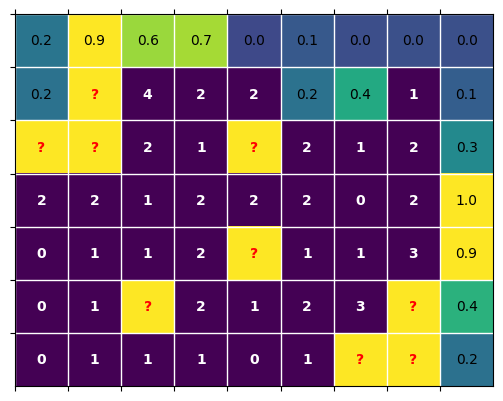

<Axes: >

In [18]:
p = model(g, np.array([14]))
pyplot_game(g[0], mine_probs=p[0])

In [19]:
g = Game(16, 30, 99, n=1)
g.random_open(0.3)
g.random_flags(0.3)

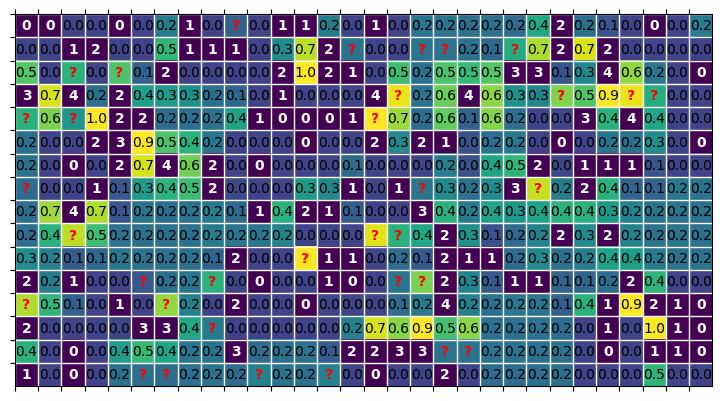

<Axes: >

In [20]:
p = model(g.game_state(), g.mines_n)
g.pyplot_game(0, mine_probs=p[0])

[ True]
[False]


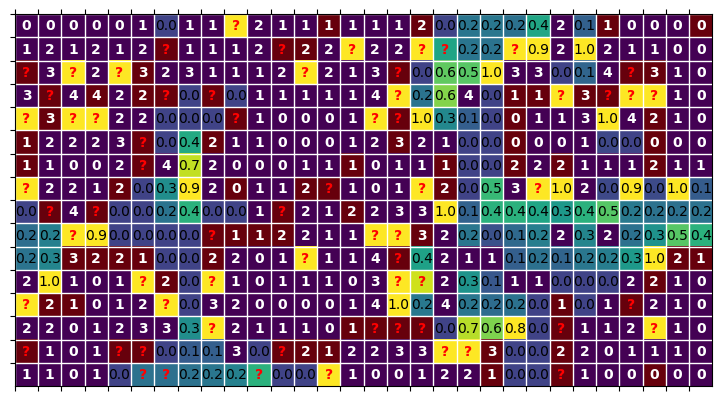

<Axes: >

In [21]:
player.play(g, turns = 2)
print(g.active_games)
print(g.won)
p = model(g.game_state(), g.mines_n)
g.pyplot_game(0, mine_probs=p[0], hightlight_losing_only=False, print_zeros= True) # highlight newly opened in red

[False]
[False]
[0.99737533]


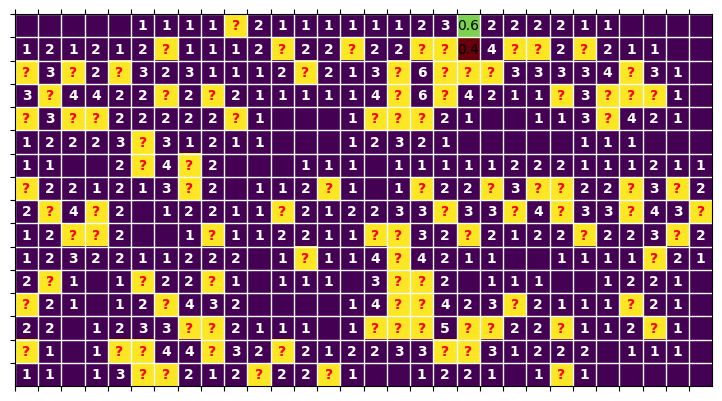

<Axes: >

In [22]:
player.play(g) # play untill the end
print(g.active_games)
print(g.won)
print(g.scores())
p = model(g.game_state(), g.mines_n)
g.pyplot_game(0, mine_probs=p[0], print_zeros=False)

In [25]:
games = Game(16, 30, 99, 1000)
games.random_open(0.1)
player.play(games)
print(f'average score: {np.average(games.scores(final_only=True))}')
print(f'win rate: {games.win_rate()}')

average score: 0.8117532808398951
win rate: 0.254
